### Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
from IPython.display import clear_output
from matplotlib import pyplot as plt

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [2]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/homeworks_basic/Lab2_DL/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()

TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
headline_indices = [0]

for i in range(len(text)):
  if len(text[i]) < 10:
    headline_indices.append(i)
  text[i] = text[i].lower()[2::]

paragraphs = []

for i in range(len(headline_indices)-1):
  l, r = headline_indices[i], headline_indices[i+1]
  paragraphs.append(''.join(text[l:r]))

paragraphs = [s for s in paragraphs if len(s) >= 10]

--2020-12-16 16:42:52--  https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/homeworks_basic/Lab2_DL/sonnets.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119748 (117K) [text/plain]
Saving to: ‘sonnets.txt’

sonnets.txt         100%[===================>] 116.94K  --.-KB/s    in 0.03s   

2020-12-16 16:42:53 (4.39 MB/s) - ‘sonnets.txt’ saved [119748/119748]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
class ShakeSpearDataset:
    def __init__(self, sonets, sequence_length):
        self.tokens = set()

        for sonet in sonets:
            self.tokens.update(set(sonet))
            
        self.tokens = list(sorted(self.tokens))
        self.sonets = sonets

        self.num_tokens = len(self.tokens)
        self.idx_to_token = dict((i, c) for i,c in enumerate(self.tokens))
        self.token_to_idx = dict((c, i) for i,c in enumerate(self.tokens))

    def __len__(self):
        return len(self.sonets)

    def get_batches(self, batch_size):
        batches = []

        i = 0
        while i < len(self.sonets) / batch_size:
            words = self.text[i:i+batch_size]
            batches.append(self.to_matrix(words))
            i += batch_size

        return batches


    def to_matrix(self, words, max_len=None , dtype='int32', batch_first=True):
        """Casts a list of words into rnn-digestable matrix"""
      
        pad = self.token_to_idx[' ']
        max_len = max_len or max(map(len, words))
        words_ix = np.zeros([len(words), max_len], dtype) + pad

        for i in range(len(words)):
            line_ix = [self.token_to_idx[c] for c in words[i]]
            words_ix[i, :len(line_ix)] = line_ix
            
        if not batch_first: # convert [batch, time] into [time, batch]
            words_ix = np.transpose(words_ix)

        return words_ix

In [4]:
dataset = ShakeSpearDataset(paragraphs, 40)

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [5]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

device

device(type='cuda', index=0)

In [6]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=dataset.num_tokens, emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units

        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x, hid_state=None):
        if hid_state is not None:
            output, state = self.rnn(self.emb(x), hid_state)
        else:
            output, state = self.rnn(self.emb(x))
        logits = self.hid_to_logits(output)
        
        return logits, state

    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(1, batch_size, self.num_units, requires_grad=True)


def train_rnn(model, loss_fn, opt, data, batch_size=10, n_epochs=100):
    loss_history = [[]]
    model.to(device)

    for n in range(n_epochs):
        model.train(True)
        
        for batch_ix in data.get_batches(batch_size):
            batch_ix = torch.LongTensor(batch_ix).to(device)
            logp_seq, hid_state = model(batch_ix)
            
            predictions_logp = logp_seq[:, :-1]
            actual_next_tokens = batch_ix[:, 1:]
            
            loss = loss_fn(
                predictions_logp.contiguous().view(-1, data.num_tokens),
                actual_next_tokens.contiguous().view(-1)
            )
                        
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            loss_history[-1].append(loss.item())

        clear_output(True)
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.plot(np.mean(loss_history, axis=1),label='loss')
        plt.legend()
        plt.show()
        loss_history.append([])

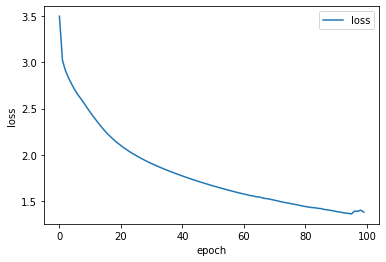

In [7]:
model_rnn = CharRNNLoop()
opt_rnn = torch.optim.Adam(model_rnn.parameters(), lr=1e-2)
criterion_rnn = nn.CrossEntropyLoss()

train_rnn(model_rnn, criterion_rnn, opt_rnn, dataset)

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [8]:
def generate_sample(char_rnn , dataset=dataset, seed_phrase='hello my friend, ', max_length=100, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    
    x_sequence = [dataset.token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([[x_sequence]], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        out, hid_state = char_rnn(x_sequence[:, :, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        out, hid_state = char_rnn(x_sequence[:, :, -1], hid_state)        
        # Be really careful here with the model output
        p_next = F.softmax(out[0, -1, :] / temperature, dim=-1).data.numpy()
        
        # sample next token and push it back into x_sequence
        #print(p_next.shape, len(dataset.tokens))
        next_ix = [np.random.choice(len(dataset.tokens), p=p_next)]
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=-1)
        
    return ''.join([dataset.tokens[ix] for ix in x_sequence.data.numpy()[0, 0]])

In [9]:
model_rnn.train(False)
model_rnn.to("cpu")

print(generate_sample(model_rnn, temperature=0.4, max_length=1000))

hello my friend, the will,
  and so dost thou world thee of that the tor should bear'st thy self thou shall self ast beauty should world thee the self thou see,
and still'd,
and sweet self in self-self-siol thy sterld,
that thou seatire wher thine owd sume the world,
when in thou for saing mind with not and should the theest thou sterly that thou for the live the tornelf convertest comanden own summer shall const thine and stars in thou thee.
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [10]:
# Your beautiful code here
# Your code here
class CharLSTMLoop(nn.Module):
    def __init__(self, num_tokens=dataset.num_tokens, emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units

        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.LSTM(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x, hid_state=None):
        if hid_state is not None:
            output, state = self.rnn(self.emb(x), hid_state)
        else:
            output, state = self.rnn(self.emb(x))

        logits = self.hid_to_logits(output)
        
        return logits, state

    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka (h0, c0)) """
        return (torch.zeros(1, batch_size, self.num_units, requires_grad=True),
                torch.zeros(1, batch_size, self.num_units, requires_grad=True))


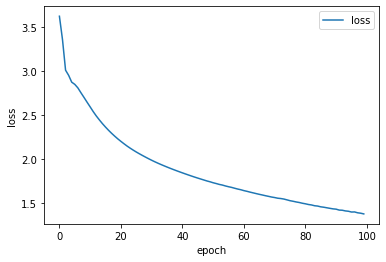

In [11]:
model_lstm = CharLSTMLoop()
opt_lstm = torch.optim.Adam(model_lstm.parameters(), lr=1e-2)
criterion_lstm = nn.CrossEntropyLoss()

train_rnn(model_lstm, criterion_lstm, opt_lstm, dataset)

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [12]:
# Text generation with different temperature values here
model_lstm.train(False)
model_lstm.to("cpu")

print(generate_sample(model_lstm, temperature=0.1, max_length=500))

hello my friend, whor the world to shall in the world to shall in the world to shall in the world of thee thou should the love to the world to the world and beauty to shall in the world of thee of make the world to shall to shall to shall in the world to shall to should the live the world to shall in the lovely to the world to should the love the world and thee of muse the world to should the love to the world to shall to shall in the world to shall to shall to shall in the world of mines the wo


In [13]:
model_lstm.train(False)
model_lstm.to("cpu")

print(generate_sample(model_lstm, temperature=0.2, max_length=500))

hello my friend, where to the world and summer of the live thou self shall in the tome the world and thee of muse thou from the world of thee of the will the world to she the world to be that the world to she that shall in the world will will in the world of meart the world to shall to should the live the beauty so fair the world and thee another thee of muse the world and beauty should the love to shall to should the live the world of mued the world to self and beauty's fair thou from the world


In [14]:
model_lstm.train(False)
model_lstm.to("cpu")

print(generate_sample(model_lstm, temperature=0.5, max_length=500))

hello my friend, and thee oun with shall hanted in thou same thee and all hear may the live thou for he sweeth when the world that in thou same thou sand pidon beauty with thou not selforim noth eld and the world stacke to that in the world i make of thee to should thou thou wich to come demackes,
  be the tell of from when thou beauty's dost paints,
tone that the lovely of thy self to should and not to thy self so she tome live, and summer liess beauty's condom he ore shall will and make thou s


In [15]:
model_lstm.train(False)
model_lstm.to("cpu")

print(generate_sample(model_lstm, temperature=1.0, max_length=500))

hello my friend, palss leed:
but, cay ald tift chidgow;
chod
aker wisthee;
' cowst oft send'
danbleth not wye yours, sime lone apine dot hasty n-ist in houn's frakance the fore!,
fore the reave low livess canty or to thic ram't, of exee of that thy endour could every,
writh eye thou should summion mights his, ans dechilf kird's decrear shates lies,
wor showe hastend;
what and bap and shall deyer'd prives it more ofnnald to thou endo!s not to thich al oft one, and to time faire threre and earte.



In [16]:
model_lstm.train(False)
model_lstm.to("cpu")

print(generate_sample(model_lstm, temperature=2.0, max_length=500))

hello my friend, i my.
ag!en mos, an! tel!ts qaymopes no! theih szouts'and:ty crelliq dakim. welslec'rr
  dilkla
uoreag'hmmot hayttinc kidow;
iv i corfbuwqtees we!
iatest timy
wi!'strok:
deace.'
then ceagerelst, sot, ho hast
ware,s lpp
bifeshel,
fad'dindomvased kitr,
tuncees,
w rogurend .axs,
afders,
frere:oy yel'd engeg'ded pat'dlrow!pt wattiot a kesk'l'! nofrer aft, baugust 'nkmlammwel ins?eft wee,
distirpe.
ptoudles ulye. do to he remeighs remadtyirqujerunt: fo?,
my l!av'mard ofh oqrmanmend,q


### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [37]:
# Saving and loading code here
def save_model(filename, model):
  state = {
      'state_dict' : model.state_dict()
  }
  torch.save(state, filename)
  print('model saved to %s' % filename)

def load_model(filename, model):
    state = torch.load(filename)
    model.load_state_dict(state['state_dict'])
    print('model loaded from %s' % filename)

In [38]:
save_model('shakespear-lstm.pth', model_lstm)

model saved to shakespear-lstm.pth


In [39]:
uploaded_model = CharLSTMLoop()
load_model('shakespear-lstm.pth', uploaded_model)

model loaded from shakespear-lstm.pth


In [40]:
uploaded_model.train(False)

print(generate_sample(uploaded_model, dataset=dataset, max_length=500))

hello my friend, lendy thom hemas world.
gomever.
not ar more the praces with thou, i a ye self-rag,
fazeth couck lese, 'from white and deself to still cadous eat she vioth
and liner evange not so and,
o! thy self or searnen and outh nechild that a encoy,
and, ge tread,
or i commonts the prontser?
and dease stew,
kard steack left breare;
tomuchert thee,
and prot,
thy coy threath buty beauty sull tal live,
and should of maind she here.
                                                             


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)